In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("GPU is not available : Training on CPU...")
else:
  print("GPU is available : Training on GPU...")

GPU is available : Training on GPU...


In [4]:
data_dir = "/content/drive/My Drive/natural_images"

In [5]:
# transformation of all the images
transformation = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(128),
                                       transforms.RandomHorizontalFlip(0.5),
                                       transforms.RandomVerticalFlip(0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])])

# all the images are stored in data_dir
full_dataset = torchvision.datasets.ImageFolder(root = data_dir,
                                                 transform = transformation)

# images are divided into train and test in the ration 7:3
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

# train and test datasets are created
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# define a loader for the training data we can iterate through in 64-image batches
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = 64,
                                           shuffle  = False)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = 64,
                                          shuffle = False)

In [6]:
data_iter = next(iter(train_loader))
images, labels = data_iter

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


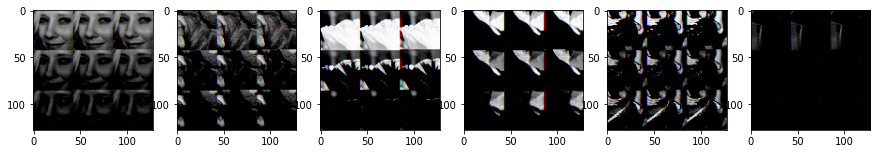

In [7]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

fig, axes = plt.subplots(figsize=(15,7), ncols = 6)
for i in range(6):
    ax = axes[i]
    images_new = images.view(64, 128,128, 3)
    img = ax.imshow(images_new[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


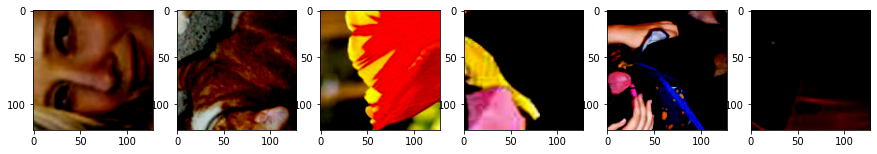

In [8]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

fig, axes = plt.subplots(figsize=(15,7), ncols = 6)
for i in range(6):
    ax = axes[i]
    img = ax.imshow(images[i].T)

In [18]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    # Conv2D layer
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1)
    self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, padding=1, stride=1)

    # Pooling layer
    self.pool = nn.MaxPool2d(kernel_size=2)

    # dropout2D layer
    self.drop2d = nn.Dropout2d(p=0.2)

    # Fully connected layer
    self.fc1 = nn.Linear(16*16*32, 1000)
    self.fc2 = nn.Linear(1000,8)

    # dropout layer for fully connected layers
    self.drop = nn.Dropout(p=0.2)

  # forward function to pass the data through the layers, defined in the init function
  def forward(self, x):
    x = F.relu(self.pool(self.conv1(x)))
    x = F.relu(self.pool(self.conv2(x)))
    x = F.relu(self.pool(self.conv3(x)))
    x = F.dropout(self.drop2d(x), training=self.training)

    # Flatten
    x = x.view(-1, 32*16*16)

    x = F.relu(self.fc1(x))
    x = self.drop(x)

    # feed the fully connected layer for prediction
    x = self.fc2(x)

    # return the output by log_softmax function
    return torch.log_softmax(x, dim = 1)

model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2d): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=8192, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=8, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)


Training the model with 10 epochs

In [21]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
                       lr = 0.001)

EPOCHS = 10

print("Training on : ", device)

for epoch in range(EPOCHS):
  for data in train_loader:
    X, y = data

    model.zero_grad()
    output = model(X)

    loss = criterion(output, y)
    loss.backward()

    optimizer.step()

  print(loss)


Training on :  cuda
tensor(0.3662, grad_fn=<NllLossBackward>)
tensor(0.2227, grad_fn=<NllLossBackward>)
tensor(0.1277, grad_fn=<NllLossBackward>)
tensor(0.2740, grad_fn=<NllLossBackward>)
tensor(0.3541, grad_fn=<NllLossBackward>)
tensor(0.0607, grad_fn=<NllLossBackward>)
tensor(0.1074, grad_fn=<NllLossBackward>)
tensor(0.0305, grad_fn=<NllLossBackward>)
tensor(0.0442, grad_fn=<NllLossBackward>)
tensor(0.0106, grad_fn=<NllLossBackward>)


Calculating Accuracy

In [36]:
def model_eval(dataloader):

  correct = 0
  total = 0

  model.eval()

  with torch.no_grad():
    for data in train_loader:
        X, y = data
        output = model(X)
        max_val, preds = torch.max(output, dim = 1)
            
        for idx, i in enumerate(output):
          if torch.argmax(i) == y[idx]:
            correct += 1
          total += 1
                
          Accuracy = (correct/total)*100
            
  return correct , total, Accuracy

In [37]:
Test_acc = model_eval(test_loader)
Train_acc = model_eval(train_loader)

In [38]:
print('Training score = {} and Testing score = {}'.format(Train_acc, Test_acc))

Training score = (4453, 5002, 89.02439024390245) and Testing score = (4481, 5002, 89.58416633346661)
